# Goal

I'm just checking that the "sliding windows" option runs at all. I'm using Jacob's MNIST_Landmarks notebook just because I happened to have it open.

In [1]:
import keras
from sklearn.model_selection import train_test_split

from umap import UMAP, ParametricUMAP

import matplotlib.pyplot as plt

import numpy as np


2024-10-24 17:44:24.006325: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 17:44:24.007355: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 17:44:24.010688: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 17:44:24.019856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 17:44:24.034434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

We'll start by loading in the MNIST handwritten digit dataset, and splitting it into 2 equal parts with sklearn's ``train_test_split`` function. This will give us two partitions to work with, one to train our original embedding and another to test it. In order to simulate new behaviour appearing in our data we remove one of the MNIST categories (digits), ``N``, from the ``x1`` partition.

In [2]:
type(1.0) is float

True

In [3]:
n_samples = -1 #-1 to use all samples.

(X, y), (_, _) = keras.datasets.mnist.load_data()
X,foo,y, bar = train_test_split(X[:n_samples], y[:n_samples], test_size=0.95, random_state=42)


In [4]:
X.shape

(2999, 28, 28)

In [5]:
x1, x2, y1, y2 = train_test_split(X[:n_samples], y[:n_samples], test_size=0.5, random_state=42)
x21, x22, y21, y22 = train_test_split(x2[:n_samples], y2[:n_samples], test_size=0.5, random_state=42)

# Reshape to 1D vectors
x1 = x1.reshape((x1.shape[0], 28*28))
x2 = x2.reshape((x2.shape[0], 28*28))
x21 = x21.reshape((x21.shape[0], 28*28))
x22 = x22.reshape((x22.shape[0], 28*28))

# Remove one category from the train dataset.
# In the case of MNIST digits, this will be the digit we are removing.
N = 2

x1 = x1[y1 != N]
x21 = x21[y21 != N]
x22 = x22[y22 != N]

y1 = y1[y1 != N]
y21 = y21[y21 != N]
y22 = y22[y22 != N]

print(x1.shape, x21.shape)

(1358, 784) (665, 784)


Firstly, we'll train a ``UMAP`` embedder on ``x1``. This is straightforward.

In [6]:
embedder = UMAP()

emb_x1 = embedder.fit_transform(x1)

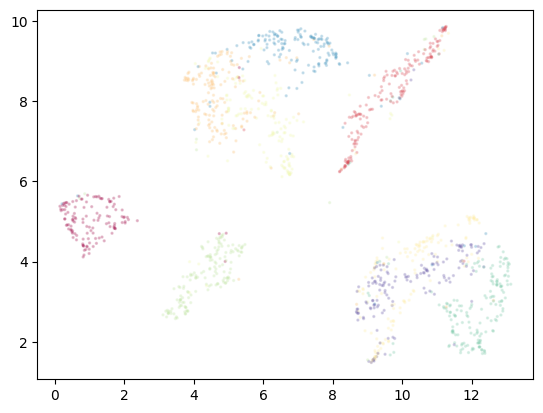

In [7]:
plt.scatter(emb_x1[:,0], emb_x1[:,1], c=y1, cmap='Spectral', s=2, alpha=0.2)

UMAP is built to be compatible with ``scikit-learn``, so passing new data through is as simple as using the ``transform`` method and passing through the new data to transform. We'll pass through ``x2``, which contains unseen examples of the original classes, and also samples from our holdout class, ``N``.

To make samples from ``N`` Stand out more, we'll over-plot them in black.

In [8]:
emb_x2 = embedder.transform(x2)

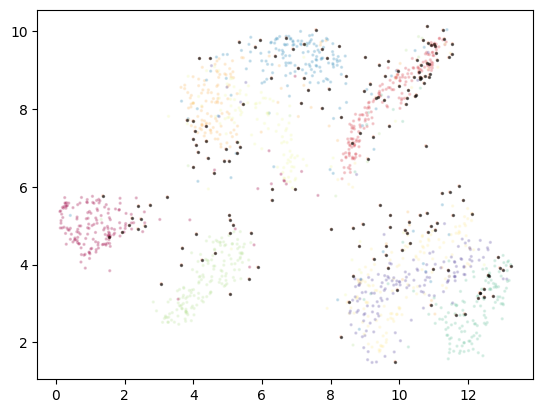

In [9]:
plt.scatter(emb_x2[:,0], emb_x2[:,1], c=y2, cmap='Spectral', s=2, alpha=0.2)
plt.scatter(emb_x2[y2==N][:,0], emb_x2[y2==N][:,1], c='k', s=2, alpha=0.5)

While our ``UMAP`` embedder has correctly handled the classes present in ``x1`` it has treated examples from class ``N`` poorly. Many of these points are concentrated on top of existing classes, with some spread out between them. This inability to generalize may or may not be an issue, depending on your use case. Parametric UMAP can provide a solution to this through updating the parametric model weights.

We will start adressing this by training a ``ParametricUMAP`` embedding model.

In [10]:
p_embedder = ParametricUMAP()

p_emb_x1 = p_embedder.fit_transform(x1)

Epoch 1/10


/work/home/amsmith/.conda/envs/jacobtest/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3948
Epoch 2/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2396
Epoch 3/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2359
Epoch 4/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2334
Epoch 5/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2318
Epoch 6/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2312
Epoch 7/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2306
Epoch 8/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2297
Epoch 9/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2287
Epoch 10/10
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2287


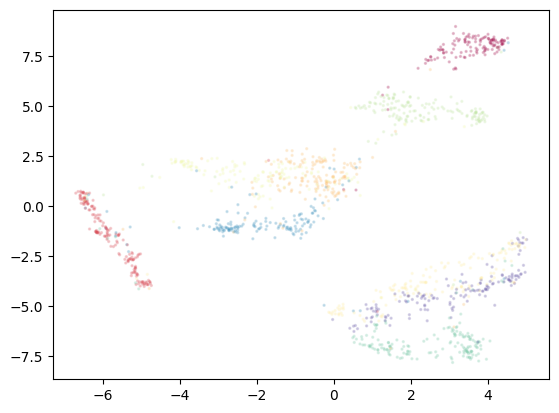

In [11]:
plt.scatter(p_emb_x1[:,0], p_emb_x1[:,1], c=y1, cmap='Spectral', s=2, alpha=0.2)

This gives us our normal UMAP result for MNIST, but with only 9 categories.

Similarly to the ``UMAP`` Model, adding new data here is straightforward, we can use the ``transform`` method. Like last time, we will overplot our samples from class ``N`` in black.

In [12]:
p_emb_x2 = p_embedder.transform(x2)

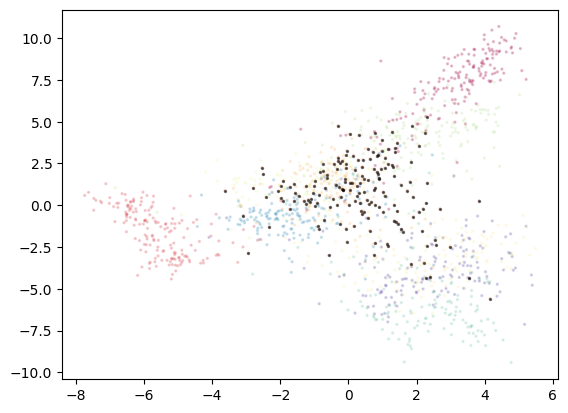

In [13]:
plt.scatter(p_emb_x2[:,0], p_emb_x2[:,1], c=y2, cmap='Spectral', s=2, alpha=0.2)
plt.scatter(p_emb_x2[y2==N][:,0], p_emb_x2[y2==N][:,1], c='k', s=2, alpha=0.5)

As with our ``UMAP`` model, the original classes present in ``x1`` have been treated reasonably, but our holdout class ``N`` has been embedded on top of existing classes.

In order to update our embedding to include the new class, we'll fine-tune our existing ``ParametricUMAP`` model. Doing this without any other changes will start from where we left off, but our embedding space's structure may drift and change. This is because our UMAP loss function is invariant to scaling, translation, and rotation, as it is only concerned with the relative positions and distances between points. 

In order to keep our embedding space more consistent, we'll use the landmarks option for ``ParametricUMAP``. We'll retrain the model on the ``x2`` partition, along with some points chosen as landmarks from ``x1``. We'll choose 1% of the samples in ``x1`` to be included, along with their current position in the embedding space.

The default ``landmark_loss_fn`` is the euclidean distance between the point's original position and it's current one. The only change we'll make is to set ``landmark_loss_weight=0.01``. We can tune this number by looking at the training history, which we'll take a look at later on.

In [14]:
# Add 1 percent of previous points as landmarks, then train model.
#
p_embedder.remove_landmarks()
p_embedder.add_landmarks(x1,sample_pct=0.01, sample_mode = "sliding_window", curr_window_vals = 1.0, landmark_loss_weight = 0.01)
p_embedder.fit(x21)



Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2995
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2659
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2633
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2615
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2617
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2608
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2601
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2600
Epoch 9/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2612
Epoch 10/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2605


ParametricUMAP(batch_size=1000, dims=[784], encoder=<Sequential name=sequential, built=True>, landmark_loss_weight=0.01)

In [16]:
x1.shape

(1358, 784)

In [15]:
p_embedder.add_landmarks(x21,sample_pct=0.01, sample_mode = "sliding_window", curr_window_vals = 2.0, landmark_loss_weight = 0.01)
p_embedder.fit(x23)


(13, 784)
6


ValueError: all input arrays must have the same shape

In [ ]:
%debug

In [ ]:
throw an error here

We now plot the different embeddings to see how well our additional training has worked. We can see here the value of this approach, our embedding space is consistent with the initial embedding, but our cluster of ``N`` samples is now neatly clustered in an appropriate part of the space, as opposed to being distributed unhelpfully on top of existing clusters.

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 18), sharex=True, sharey=True)

axs[0,0].scatter(
    emb_x1[:, 0], emb_x1[:, 1], c=y1, cmap='Spectral', s=2, alpha=0.2,
)
axs[0,0].set_ylabel('UMAP Embedding', fontsize=20)

axs[0,1].scatter(
    emb_x2[:, 0], emb_x2[:, 1], c=y2, cmap='Spectral', s=2, alpha=0.2,
)
axs[0,1].scatter(
    emb_x2[y2==N][:,0], emb_x2[y2==N][:,1], c='k', s=2, alpha=0.5,
)

axs[1,0].scatter(
    p_emb_x1[:, 0], p_emb_x1[:, 1], c=y1, cmap='Spectral', s=2, alpha=0.2,
)
axs[1,0].set_ylabel('Initial P-UMAP Embedding', fontsize=20)

axs[1,1].scatter(
    p_emb_x2[:, 0], p_emb_x2[:, 1], c=y2, cmap='Spectral', s=2, alpha=0.2,
)
axs[1,1].scatter(
    p_emb_x2[y2==N][:,0], p_emb_x2[y2==N][:,1], c='k', s=2, alpha=0.5
)

axs[2,0].scatter(
    p_emb2_x1[:, 0], p_emb2_x1[:, 1], c=y1, cmap='Spectral', s=2, alpha=0.2,
)
axs[2,0].set_ylabel('Updated P-UMAP Embedding', fontsize=20)
axs[2,0].set_xlabel(f'x1, No {N}s', fontsize=20)

axs[2,1].scatter(
    p_emb2_x2[:, 0], p_emb2_x2[:, 1], c=y2, cmap='Spectral', s=2, alpha=0.2,
)
axs[2,1].scatter(
    p_emb2_x2[y2==N][:,0], p_emb2_x2[y2==N][:,1], c='k', s=2, alpha=0.5,
)
axs[2,1].set_xlabel('x2, All Classes', fontsize=20)

plt.tight_layout()

It is worth double checking here that the landmark loss is not too constraining, we still would like a good UMAP structure.
To do so, we can interrogate the history of our embedder, which will retain the history through our re-training steps. Plotting it, we can identify the spike in loss where we introduce ``x2``, and can confirm that the resulting loss is comparable to the loss from our initial training on ``x1``. This tells us that the model is not having to compromise too much between the UMAP loss and the landmark loss. If this were not the case, it could potentially be improved by lowering the ``landmark_loss_weight`` attribute of our embedder object. There is a tradeoff to be made here between the consistency of the space and minimizing UMAP loss, but the key is we have smooth variation in the embedding space, which will make downstream tasks easier to adjust.

In [ ]:
plt.plot(p_embedder._history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')

It is also worth noting that, due to the relatively straightforward nature of the MNIST dataset, we have achieved good results with just the default model and training regime of Parametric UMAP. Options for improving these results include:
- Using a CNN architecture instead of the default dense layers.
- Training for more epochs.
- Selecting the landmark points intelligently (e.g. points descriptive of the clusters).
- Trying different ``landmark_loss_fn`` options instead of the default euclidean distance, or different values for ``landmark_loss_weight``.